In [1]:
import sys
sys.path.append('/home/jovyan/workspace')

In [2]:
%%sh
rm -rf '../data/test'

In [3]:
import planetengine
from planetengine import functions as pfn
import numpy as np
from timeit import timeit

In [4]:
system = planetengine.systems.isovisc.build(res = 4)
planetengine.initials.apply(
    {'temperatureField': planetengine.initials.sinusoidal.IC(freq = 1.)},
    system,
    )
system.solve()

In [5]:
variable = pfn.Variable(system.velocityField)
constant = pfn.Constant(2.)
parameter = pfn.Parameter(lambda: variable.ranges[0])
shape = pfn.Shape(np.array([[0.2, 0.1], [0.9, 0.3], [0.8, 0.7], [0.4, 0.9]]))

In [7]:
def makevar():
    var = variable ** constant
    var = pfn.Region(var, shape)
    var = pfn.Component.rad(var)
    var = pfn.Gradient.mag(var)
    var = pfn.Normalise(var, system.temperatureField)
    var = pfn.Quantiles.median(var)
    var = pfn.HandleNaN.zero(var)
    return var

In [8]:
print(round(timeit(makevar, number = 1), 3))

0.745


/home/jovyan/workspace/planetengine/utilities.py:297: RuntimeWarning: invalid value encountered in double_scalars
  ranges = np.array([maxVal - minVal for minVal, maxVal in scales])


In [9]:
var = makevar()

In [10]:
print(var._has_changed())
print(var._has_changed())
system.iterate()
print(var._has_changed())
print(var._has_changed())

True
False
True
False


Fitted 1 variables to the figure.
HandleNaN{Quantiles_ntiles=2{Normalise{Gradient_gradient=mag{Component_component=rad{Region{Operation_uwop=pow{Variable_varName=anon{};Constant_val=arr{[ 2.]}{}};Shape_varName=anon{}}}};Variable_varName=anon{}}};Constant_val=arr{[ 0.]}{}} [[ 0.  0.]]



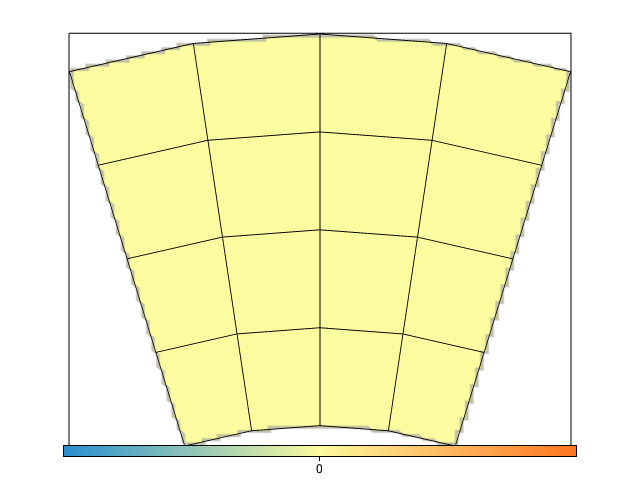

In [11]:
planetengine.quickShow(system.mesh, var)

In [12]:
zeroed = pfn.HandleNaN.zero(var)
intVar = pfn.Integral.volume(zeroed)

In [13]:
print(intVar.evaluate())
print(intVar.evaluate())
system.iterate()
print(intVar.evaluate())
print(intVar.evaluate())

[[ 0.]]
[[ 0.]]
[[ 0.]]
[[ 0.]]


In [14]:
def testfn():
    freshsteps = []
    stalesteps = []
    system.iterate()
    for i in range(10):
        system.iterate()
        freshsteps.append(timeit(intVar.evaluate, number = 1))
        for i in range(10):
            stalesteps.append(timeit(intVar.evaluate, number = 1))
    average_fresh = round(sum(freshsteps) / len(freshsteps), 3)
    average_stale = round(sum(stalesteps) / len(stalesteps), 3)
    ratio = round(average_fresh / average_stale, 3)
    return(average_fresh, average_stale, ratio)
print(testfn())

(0.044, 0.002, 22.0)
